In [7]:
from qutip import basis, sigmax, sigmaz, sigmay, Options 
from qutip.solver.heom import DrudeLorentzBath
from qutip.solver.heom import HEOMSolver
from qutip.solver.heom import DrudeLorentzPadeBath
from qutip.solver.heom import BathExponent
import math
__all__ = ['parallel_map', 'serial_map', 'loky_pmap', 'mpi_pmap']

import multiprocessing
import os
import sys
import time
import threading
import concurrent.futures
import warnings
from qutip.ui.progressbar import progress_bars
from qutip.settings import available_cpu_count
from scipy.fft import fft, ifft 
from scipy.special import shichi
from mpmath import meijerg
import scipy
import matplotlib.pyplot as plt
import qutip

import numpy as np 
import time 




# More flexibel solver for custom bath
from qutip.solver.heom import HSolverDL
from qutip.solver.heom import BosonicBath

import qutip.solver.brmesolve as brmesolve

In [8]:
"""Define Constants"""
#hbar, kb=1
import scipy.special


we=1 # With hbar = 1 this is the upper energy
wg=0# ground state
ve=0.1 #  ground state frequencie from the exited atomic state in 0.1*we 
vg=0.1 # ground state frequencie from the ground atomic state 
λ1=0.5# dim less coupling constant depending on the shift of the energy minima shifts in space
g1=0.1 #couplig to the atom to the bath   
g2=0.1 #couplig to the vibronic modes to the bath 
tlist = np.linspace(0,60, 1000) # 40 times atomic frequencie 4 times vibronic
#### ground parameters
λ2=(vg**2-ve**2)/(4*vg**2) # dim less coupling constant depending on the vibronic freq 
w0=we- wg + λ1**2 *vg**3 /ve**2
w00 = we - wg + (ve - vg )/2


beta=15 #temp Einheit von  hb*omega durch kb
A=-λ1/(1+4*λ2)
#A=-λ1*(vg**2/ve**2)

#rs=2*(2*np.pi*1J+np.log(1+4*λ2)**0.25)
rs=1/4*(np.log(ve**2/vg**2))

def nb(w):
    return np.float128(1/(np.exp((w) * beta)-1))
N=20# size of the vibronic hilbi space 
#tlist=np.linspace[0,1,10]
# operators
b  = qutip.tensor(qutip.qeye(2),qutip.destroy(N)) #ladder operator of the vibronic modes 
P12 = qutip.tensor(basis(2,0)*basis(2,1).dag(),qutip.qeye(N))
P21 = qutip.tensor(basis(2,1)*basis(2,0).dag(),qutip.qeye(N))
P11 = qutip.tensor(basis(2,0)*basis(2,0).dag(),qutip.qeye(N))
P22 = qutip.tensor(basis(2,1)*basis(2,1).dag(),qutip.qeye(N))
psi0 = qutip.tensor(basis(2,1),basis(N,0))   #|e,0>
rho0=qutip.tensor(basis(2,1)*basis(2,1).dag(),basis(N,0)*basis(N,0).dag()) #|e,0><e,0|

#System hamiltonian
H= vg*b.dag()*b +w0*P21*P12 + λ1*vg*(b+b.dag())*P21*P12  + λ2*vg*(b+b.dag())**2  *P21*P12     
    
H_diag=vg*P12*P21*b.dag()*b+ (vg*b.dag()*b+w00)*P21*P12
 
O1=P12+P21
O2=b+b.dag()
wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def gamma(wx, wc, g):
    term1 = scipy.special.gammainc(0, -wx / wc)  # Gamma[0, -w0/wc]
    term2 = -np.log(-wx)
    term3 = np.log(-wx / wc)
    term4 = np.log(wc)
    
    prefactor = g / (np.pi * wc)
    bracket = (wc + wx * np.exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket.real())

print(scipy.special.gammainc(0,1))
evals , ekets = H.eigenstates()
evals2 , ekets2 = H_diag.eigenstates()
print(H_diag)
#print(ekets,ekets2)
state1=qutip.tensor( basis(2,1),qutip.basis(N,0))
state2=qutip.tensor(basis(2,0),qutip.basis(N,1))
#print(state1.dag()*H_diag*state2)
def SS(H):
    return (-H*beta).expm()/((-H*beta).expm().tr())
print((SS(H)*P22).tr())
print((SS(H_diag)*P22).tr())
"""wc = 10.0      # Cutoff-Frequenz ω_c
g = 0.1        # Kopplungskonstante

# Berechnung der Lamb-Shift-Funktion
def lamb_shift(w0, wc, g):
    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]
    term2 = -log(-w0)
    term3 = log(-w0 / wc)
    term4 = log(wc)
    
    prefactor = g / (pi * wc)
    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)
    
    return float(prefactor * bracket)"""


1.0
Quantum object: dims=[[2, 20], [2, 20]], shape=(40, 40), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.1 0.  ... 0.  0.  0. ]
 [0.  0.  0.2 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 2.7 0.  0. ]
 [0.  0.  0.  ... 0.  2.8 0. ]
 [0.  0.  0.  ... 0.  0.  2.9]]
3.0590222690921e-07
3.0590222692562446e-07


'wc = 10.0      # Cutoff-Frequenz ω_c\ng = 0.1        # Kopplungskonstante\n\n# Berechnung der Lamb-Shift-Funktion\ndef lamb_shift(w0, wc, g):\n    term1 = gammainc(0, -w0 / wc, regularized=False)  # Gamma[0, -w0/wc]\n    term2 = -log(-w0)\n    term3 = log(-w0 / wc)\n    term4 = log(wc)\n    \n    prefactor = g / (pi * wc)\n    bracket = (wc + w0 * exp(w0 / wc)) * (term1 + term2 + term3 + term4)\n    \n    return float(prefactor * bracket)'

In [9]:
#Diagonalization
D_op = qutip.displace(N, A)
print(D_op)
D_op= qutip.tensor(  qutip.qeye(2),D_op )

#S_op = qutip.tensor(qutip.qeye(2),  S_op)
S_op = qutip.squeezing(b,b, rs)

U = P12*P21 +(D_op * S_op*P21*P12)
# Transformation auf sigma p12r is in the diagonalized frame
P12r = U.dag() * P12 * U
P21r = U.dag() * P21 * U
c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P21*P12
#P12r=D_op*S_op*P12
#P21r=P12r.dag()

Quantum object: dims=[[20], [20]], shape=(20, 20), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 8.82496903e-01  4.41248451e-01  1.56004886e-01  4.50347315e-02
   1.12586829e-02  2.51751802e-03  5.13886215e-04  9.71153661e-05
   1.71677335e-05  2.86128891e-06  4.52409501e-07  6.82032984e-08
   9.84429818e-09  1.36515853e-09  1.82426982e-10  2.35512222e-11
   2.94390272e-12  3.57001177e-13  4.20672178e-14  4.88363379e-15]
 [-4.41248451e-01  6.61872677e-01  5.46017101e-01  2.47691023e-01
   8.44401215e-02  2.39164212e-02  5.90969147e-03  1.31105744e-03
   2.66099869e-04  5.00725560e-05  8.82198526e-06  1.46637092e-06
   2.31341007e-07  3.48115426e-08  5.01674202e-09  6.94761054e-10
   9.27329351e-11  1.19595458e-11  1.49334045e-12  1.83366751e-13]
 [ 1.56004886e-01 -5.46017101e-01  4.68826479e-01  5.81159643e-01
   3.20433913e-01  1.25055823e-01  3.93350652e-02  1.05924916e-02
   2.52803437e-03  5.46779744e-04  1.08846596e-04  2.01709490e-05
   3.51006912e-06  5.77498416e-07  9.0

In [10]:
A=-0.5
#rotationsmatrix anders definiert 
D_opt=(A*(b.dag()-b)).expm()
S_opt=(1/2*rs*(b*b-b.dag()*b.dag())).expm() #seldmade
Ut = P12*P21 +(D_opt * S_opt*P21*P12)
# Transformation auf sigma
#print(P12*P21 +D_opt *P21*P12,(P12*P21 +D_opt *P21*P12).dag()*b*(P12*P21 +D_opt *P21*P12))
#print(D_op,D_opt)
P12rt = Ut.dag() * P12 * Ut

#print(P12rt,P12r,D_op*S_op*P12)
U1 = P12*P21 +D_op *P21*P12
U2 = P12*P21 +S_op *P21*P12

#U=U1*U2
br=U.dag() *b * U
brt=Ut.dag() *b * Ut# selfmade disp
br3=U1.dag() *b * U1
br2= b* P12*P21  +(b *np.cosh(rs)  - b.dag()*np.sinh(rs)+A*np.cosh(rs))*P21*P12
be = (np.cosh( rs) *b + np.sinh( rs)* b.dag() + A* np.exp(rs) )*P21*P12

print(b+A*P22,((P11+D_opt*P22).dag())*b*(P11+D_opt*P22),br3)
#print(U.dag() *H *U)
#c=b* P12*P21  +(b *np.cosh(rs)  - b*np.sinh(rs))*P21*P12

P12r=P12rt
P21r=P12rt.dag()
#rho0r=Ut.dag()*rho0*Ut #
#rho0r=U.dag()* rho0 *U #neue  BAsis
H_ls=c.dag()*c+P21r*P12r+A*np.cosh(rs)*(P22+P11)*(A*np.cosh(rs)*(P22+P11)).dag()


Quantum object: dims=[[2, 20], [2, 20]], shape=(40, 40), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.41421356 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.5         4.24264069
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.5
   4.35889894]
 [ 0.          0.          0.         ...  0.          0.
  -0.5       ]] Quantum object: dims=[[2, 20], [2, 20]], shape=(40, 40), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.41421356 ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.62118849  2.05546423
   0.99605167]
 [ 0.          0.         

/home/sander/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


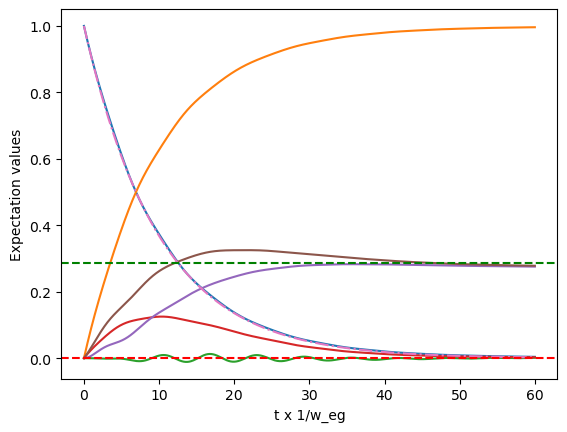

In [11]:
# decay 

########################################################################################################
gamma_1=0.1
gamma_2=0.1
c_op_list=[]

c_op_list.append(np.sqrt((nb(w0)+1)*gamma_1)*P12)
c_op_list.append(np.sqrt((nb(w0))*gamma_1)*P21)
c_op_list.append(np.sqrt((nb(vg)+1)*gamma_2)*b*P11)
c_op_list.append(np.sqrt((nb(vg))*gamma_2)*b.dag()*P11)
c_op_list.append(np.sqrt((nb(ve)+1)*gamma_2)*b*P22)
c_op_list.append(np.sqrt((nb(ve))*gamma_2)*b.dag()*P22)
Resul_Lindblad=qutip.mesolve(H, psi0, tlist, [c_op_list], [P22, P11,P12,b.dag()*b*P22,b.dag()*b*P11,b.dag()*b*P22+b.dag()*b*P11])

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad.expect[0])
ax.plot(tlist, Resul_Lindblad.expect[1])
ax.plot(tlist, Resul_Lindblad.expect[2])
ax.plot(tlist, Resul_Lindblad.expect[3])
ax.plot(tlist, Resul_Lindblad.expect[4])
ax.plot(tlist, Resul_Lindblad.expect[5])
P1 = np.exp(-beta * w0 / 2) / (np.exp(-beta * w0 / 2) + np.exp(beta * w0 / 2))
ax.plot(tlist,np.exp(-gamma_1 *(2*nb(w00)+1)*tlist)+P1*(1-np.exp(-gamma_1 *(2*nb(w00))*tlist)),linestyle='dashdot') 
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
#ax.legend(("Pe", "Pg","P12","N * P22 ","N * P11","N*P22+N*P11"))
ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
ax.axhline(y=(np.abs((SS(H)*(b.dag()*b*(P22+P11))).tr())), xmin=0, xmax=40, color='g', linestyle='--')
#ax.axhline(y=1/(np.exp(beta*vg)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()

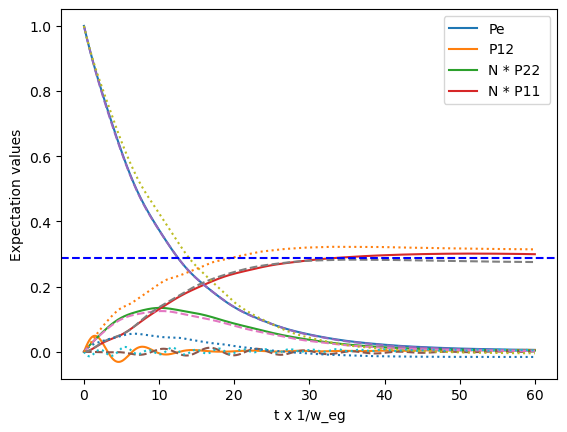

Quantum object: dims=[[2, 20], [2, 20]], shape=(40, 40), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00 -3.58680186e-17 -1.01636740e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.58680186e-17  1.00000000e+00 -6.78739838e-17 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.01636740e-17 -6.78739838e-17  1.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] Quantum object: dims=[[2, 20], [2, 20]], shape=(40, 40), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0.

In [12]:
gamma_1_diag=0.1
gamma_2_diag=0.1
c_op_list_diag=[]

c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_1_diag)*P12r)
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_1_diag)*P21r)
c_op_list_diag.append(np.sqrt((nb(vg)+1)*gamma_2_diag)*c*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(vg))*gamma_2_diag)*c.dag()*P12r*P21r)
c_op_list_diag.append(np.sqrt((nb(ve)+1)*gamma_2_diag)*c*P21r*P12r)
c_op_list_diag.append(np.sqrt((nb(ve))*gamma_2_diag)*c.dag()*P21r*P12r)


c_op_list_diag.append(np.sqrt((nb(w00)+1)*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
c_op_list_diag.append(np.sqrt((nb(w00))*gamma_2_diag)*A *np.cosh(rs)*(P21*P12+P12*P21))
#cross coreleation thermes slow
Lk_min = qutip.spre(c) * qutip.spost(P12r.dag()) - 0.5 * qutip.spre(P12r.dag() * c) - 0.5 * qutip.spost(P12r.dag() * c)
Lk_min2 = qutip.spre(c.dag()) * qutip.spost(P12r) - 0.5 * qutip.spre(P12r * c.dag()) - 0.5 * qutip.spost(P12r * c.dag())
Lk_plu = qutip.spre(P12r.dag()) * qutip.spost(c) - 0.5 * qutip.spre(c*P12r.dag() ) - 0.5 * qutip.spost(c*P12r )

Resul_Lindblad_diag=qutip.mesolve(H_diag, U.dag()*rho0*U, tlist, [c_op_list_diag], [P21r*P12r, P12r*P21r,P12r,U.dag()*b.dag()*b*U*P21r*P12r,U.dag()*b.dag()*b*U*P12r*P21r])
Resul_Lindblad_diag_cross=qutip.mesolve(H_diag+H_ls, rho0, tlist, [c_op_list_diag,gamma_1*(nb(w00+vg)+1)*(Lk_min+Lk_min2)+gamma_1*(nb(w00+vg))*(Lk_plu+Lk_plu.dag())], [P21*P12, P12*P21,P12,b.dag()*b*P21*P12,b.dag()*b*P12*P21])

fig, ax = plt.subplots()
ax.plot(tlist, Resul_Lindblad_diag.expect[0])
ax.plot(tlist, Resul_Lindblad_diag.expect[2])
ax.plot(tlist, Resul_Lindblad_diag.expect[3])
ax.plot(tlist, Resul_Lindblad_diag.expect[4])

ax.plot(tlist, Resul_Lindblad.expect[0],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[2],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[3],linestyle="--")
ax.plot(tlist, Resul_Lindblad.expect[4],linestyle="--")

ax.plot(tlist, Resul_Lindblad_diag_cross.expect[0],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[2],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[3],linestyle=":")
ax.plot(tlist, Resul_Lindblad_diag_cross.expect[4],linestyle=":")
ax.set_xlabel('t x 1/w_eg')
ax.set_ylabel('Expectation values')
ax.legend(("Pe","P12","N * P22 ","N * P11"))
#ax.axhline(y=(np.abs((SS(H_diag)*(b.dag()*b*(P22+P11))).tr())), xmin=0, xmax=40, color='g', linestyle='--')
#ax.axhline(y=(SS(H)*P22).tr(), xmin=0, xmax=40, color='r', linestyle='--')
ax.axhline(y=1/(np.exp(beta*vg)-1), xmin=0, xmax=40, color='b', linestyle='--')
plt.show()
print(P12r*P21r,P12*P21,P21*P12+P12*P21)